### In this case, the starting configuration is the actual manually optimized structure

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import cmasher as cmm
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import plotly.express as px
import scipy
from epics import ca
from IPython.display import Image, display_png

ca.finalize_libca()

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [3]:
%matplotlib inline

In [4]:
from epics import ca
ca.finalize_libca()

In [5]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [6]:
exp_type = "peak_fwhm_nlpi"

In [7]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type / 'all_motors_beam'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [8]:
!ls {data_base_dir}

autofocusing.ini
initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-22_images
peak_fwhm_nlpi_moo_100_2022-11-22_steps
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_14:19.gz


## peak_fwhm_150_2022-11-18

In [9]:
!ls {data_base_dir}

autofocusing.ini
initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-22_images
peak_fwhm_nlpi_moo_100_2022-11-22_steps
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_14:19.gz


In [10]:
log_file = Path(data_base_dir / 'peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_14:19.gz')
log_file.exists()

True

In [11]:
hist_dir = Path(data_base_dir / 'peak_fwhm_nlpi_moo_100_2022-11-22_steps')
hist_dir.exists()

True

In [12]:
base_out_dir = Path('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/peak_fwhm_nlpi')
base_out_dir.mkdir(exist_ok=True)

In [13]:
out_dir = base_out_dir / 'all_motors_beam'
out_dir.mkdir(exist_ok=True)

In [14]:
study = analysis.create_study_from_trials(log_file, n_objectives=3)

[I 2023-07-02 17:08:52,087] A new study created in memory with name: no-name-132080bf-c1c9-4f7f-9df4-c9f29b6b4d84


Assuming minimization for all objectives.


In [15]:
n_steps = len(study.trials)

In [16]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [17]:
reference = {'hist': hists[0], 'dw': study.trials[0].user_attrs['dw']}
joblib.dump(reference, 'reference_beam.joblib', compress=5)

['reference_beam.joblib']

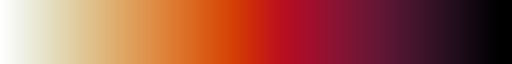

In [18]:
m2 = apu.CMAP
m2

In [19]:
max_count = np.max([h.data_2D for h in hists])

In [20]:
max_count

64528.0

Trial values: peak_distance 2.244e-02 fwhm 1.985e-02 nlpi -1.081e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3943914793975353, 'h_fwhm': 0.01690782769800947, 'h_centroid': -0.0017291571494513214, 'h_peak': -0.0224353867531264, 'v_sigma': 0.4622007832186319, 'v_fwhm': 0.010404064087534692, 'v_centroid': 0.0055967176937886665, 'v_peak': -0.00032512700273549627, 'integral_intensity': 278.8805207014857, 'peak_intensity': 49412.332, 'gaussian_fit': {}}}


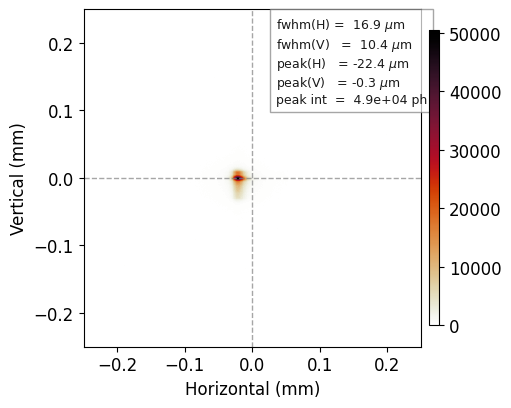

In [28]:
print(
    f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} "
    + f"nlpi {study.trials[0].values[2]:4.3e}"
)
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)

dwd = dict(**study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary)


plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(
    hists[0].hh,
    hists[0].vv,
    hists[0].data_2D.T[::-1],
    cmap=m2,
    #norm=mpl.colors.LogNorm(100, max_count),
    rasterized=True,
)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title("Initial")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")
text = text.replace("e+", "e")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph"
)
ax.text(
    0.035, 0.11, text, color="black", alpha=0.9, fontsize=9, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)
plt.savefig(f"{out_dir}/manually_optimized.svg", bbox_inches="tight", dpi=600)
plt.show()

In [29]:
study.trials[0].params

{'hb_1': 0.0,
 'hb_2': 0.0,
 'hb_pitch': 0.0,
 'hb_trans': 0.0,
 'vb_bender': 0.0,
 'vb_pitch': 0.0,
 'vb_trans': 0.0}

In [30]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [32]:
nash_trial.params

{'hb_1': 2.0,
 'hb_2': -2.0,
 'hb_pitch': -0.00010000000000000005,
 'hb_trans': -0.0016999999999999967,
 'vb_bender': 10.0,
 'vb_pitch': 0.00010000000000000026,
 'vb_trans': -0.002199999999999997}

In [22]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[97, 19, 89, 25]
18 [0.005141044125161722, 0.01731520387632536, -10.987288475036621]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39625545587721256, 'h_fwhm': 0.014306623436777244, 'h_centroid': -0.0009045432020981514, 'h_peak': -0.004877257989810118, 'v_sigma': 0.4644619774930496, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.0054774824564656766, 'v_peak': 0.0016256350136771857, 'integral_intensity': 276.07962559766685, 'peak_intensity': 59117.89, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.01731520387632536


Trial number 18
Trial values: peak_distance 5.141e-03 fwhm 1.732e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39625545587721256, 'h_fwhm': 0.014306623436777244, 'h_centroid': -0.0009045432020981514, 'h_peak': -0.004877257989810118, 'v_sigma': 0.4644619774930496, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.0054774824564656766, 'v_peak': 0.0016256350136771857, 'integral_intensity': 276.07962559766685, 'peak_intensity': 59117.89, 'gaussian_fit': {}}}
Params:
{'hb_1': 2.0, 'hb_2': -2.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.0016999999999999967, 'vb_bender': 10.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': -0.002199999999999997}


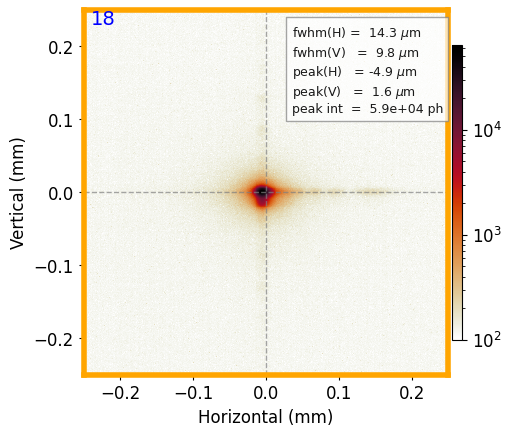

Trial number 38
Trial values: peak_distance 1.206e-01 fwhm 1.658e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3972997781623852, 'h_fwhm': 0.0149569245020853, 'h_centroid': 0.0012887751266546787, 'h_peak': 0.056901343214451186, 'v_sigma': 0.46592538230364366, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.001724184335414991, 'v_peak': 0.10631652989448999, 'integral_intensity': 274.52964090970113, 'peak_intensity': 63102.145, 'gaussian_fit': {}}}
Params:
{'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': -0.0008500000000000001, 'hb_trans': 0.002800000000000004, 'vb_bender': 9.0, 'vb_pitch': 0.0010400000000000001, 'vb_trans': 0.026800000000000004}


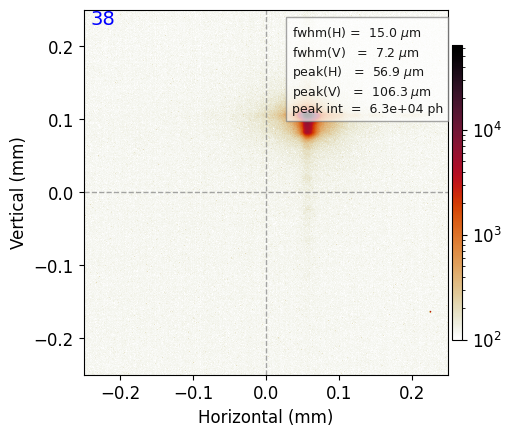

Trial number 53
Trial values: peak_distance 1.175e-02 fwhm 1.717e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39729961351168547, 'h_fwhm': 0.015607225567393357, 'h_centroid': -0.000656526759987841, 'h_peak': 0.0029263547938860714, 'v_sigma': 0.4658136540330734, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.005163225533433374, 'v_peak': 0.011379445095740449, 'integral_intensity': 274.15395101326925, 'peak_intensity': 57108.332, 'gaussian_fit': {}}}
Params:
{'hb_1': 3.0, 'hb_2': -4.0, 'hb_pitch': -4.9999999999999914e-05, 'hb_trans': -0.0186, 'vb_bender': 11.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.0058}


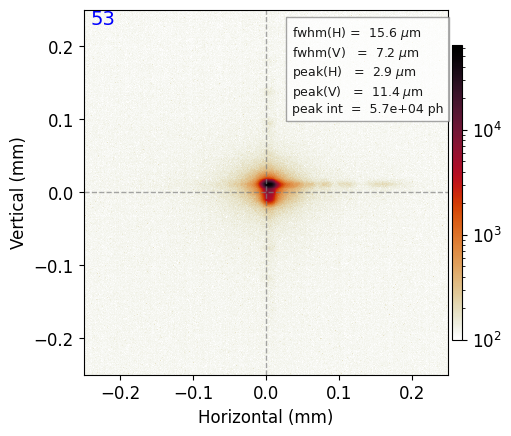

Trial number 78
Trial values: peak_distance 9.209e-02 fwhm 1.573e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3977066001319028, 'h_fwhm': 0.013656322371469187, 'h_centroid': -0.0037301447519993425, 'h_peak': -0.08356368689207971, 'v_sigma': 0.4661181976475602, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.007105682407930497, 'v_peak': -0.038690113325517854, 'integral_intensity': 273.58126884222804, 'peak_intensity': 53902.875, 'gaussian_fit': {}}}
Params:
{'hb_1': 1.0, 'hb_2': 1.0, 'hb_pitch': 0.0007500000000000002, 'hb_trans': -0.011, 'vb_bender': 7.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': 0.027600000000000006}


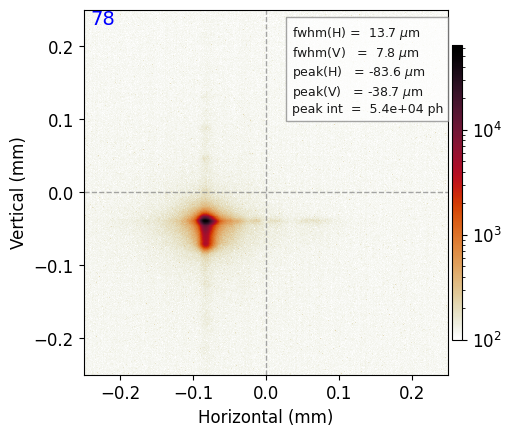

In [33]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    
    
    dwd= dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)

    print('Params:')
    print(t.params)
    

    plt.figure(figsize=[5,5], constrained_layout=True)
    plt.pcolormesh(hists[t.number].hh, hists[t.number].vv, hists[t.number].data_2D.T[::-1], cmap=m2, 
                   norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
    plt.xlim(-0.25,0.25)
    plt.ylim(-0.25,0.25)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    #plt.title(t.number)
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')

    text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph")
    
    ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
    plt.text(-0.24, 0.23, t.number, fontsize=14, color='blue')
    plt.savefig(f'{out_dir}/pareto_{t.number}.svg', bbox_inches='tight', dpi=600)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.show()

In [26]:
study.best_trials[0].values

[0.005141044125161722, 0.01731520387632536, -10.987288475036621]

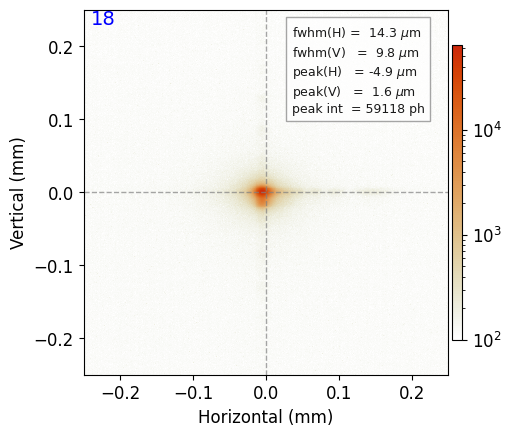

In [37]:

tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]
plt.figure(figsize=[5,5], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T[::-1], cmap=m2, 
               norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
#plt.title(t.number)
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')


text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
             fr"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph")
ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.text(-0.24, 0.23, tnum, fontsize=14, color='blue')
plt.savefig(f'{out_dir}/pareto_NS.svg', bbox_inches='tight', dpi=600)
plt.show()

In [38]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['peak_distance', 'fwhm', 'nlpi'])

In [39]:
pareto_df

,number,peak_distance,fwhm,nlpi,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
18,18,0.005141,0.017315,-10.987288,-0.004877,0.001626,0.014307,0.009754,59117.890625
38,38,0.120586,0.016579,-11.052510,0.056901,0.106317,0.014957,0.007153,63102.144531
53,53,0.011750,0.017168,-10.952705,0.002926,0.011379,0.015607,0.007153,57108.332031
78,78,0.092086,0.015728,-10.894939,-0.083564,-0.038690,0.013656,0.007803,53902.875000


In [40]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]


In [41]:
c2

[38, 53, 78]

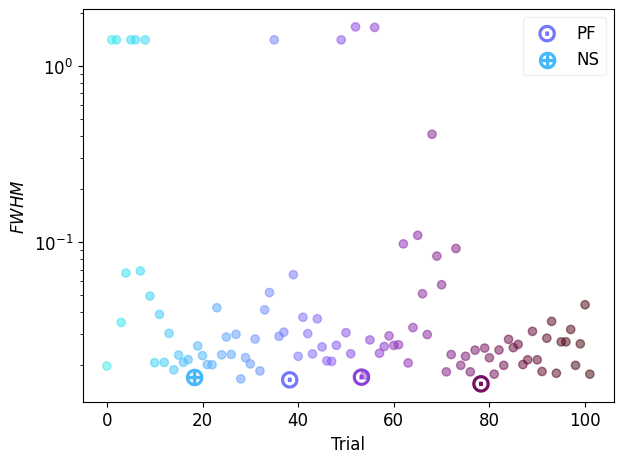

In [42]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values



plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='NS')

plt.xlabel('Trial')
plt.ylabel('$FWHM$')
plt.yscale('log')
#for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
#plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
#plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

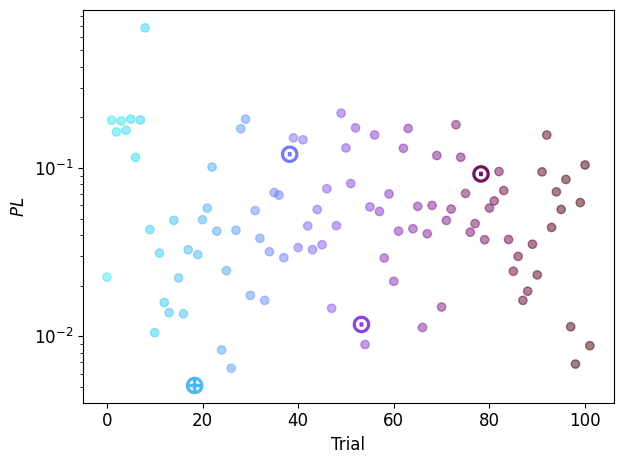

In [43]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='NS')

plt.xlabel('Trial')
plt.ylabel('$PL$')
plt.yscale('log')
#for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
#plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
#plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

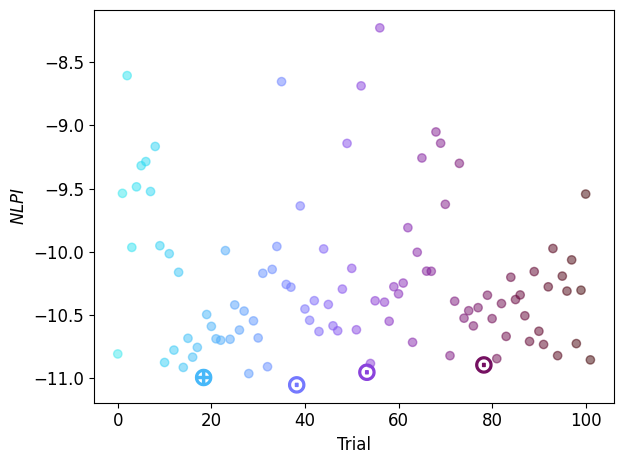

In [44]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='NS')

plt.xlabel('Trial')
plt.ylabel('$NLPI$')
plt.tight_layout()
plt.show()

In [45]:
ground = {'peak_distance': 2.244e-02, 'fwhm': 1.985e-02, 'nlpi': -1.081e+01}

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_69840/1832789143.py:25: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.463644618893228 4.352882222222222


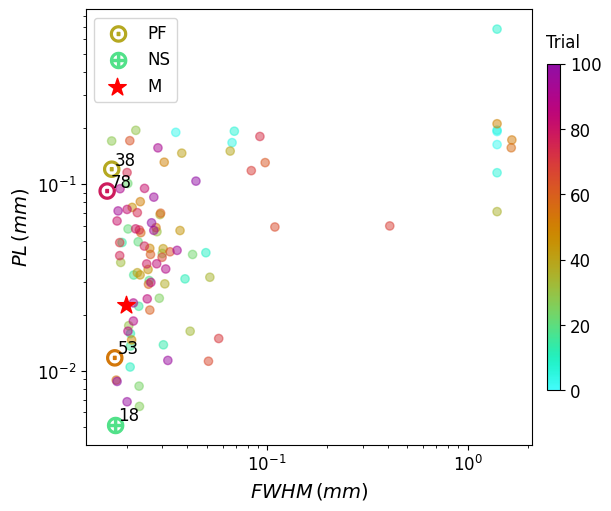

In [46]:

x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

fig = plt.figure(figsize=[6,5],constrained_layout=True)
plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.tropical_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.tropical_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.tropical_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='NS')

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords='offset points')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$FWHM\,(mm)$', fontsize=14)
plt.ylabel('$PL\,(mm)$', fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location='right')
#cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 105.0,'Trial')
#cbar.ax.set_xlabel('Trial')#, fontsize=14)

plt.scatter(ground['fwhm'], ground['peak_distance'], color='red', marker='*', s=175, label='M')
plt.legend(loc='best')
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
plt.savefig(f'{out_dir}/pareto_fwhm_pl.svg', bbox_inches='tight', dpi=600)
plt.show()

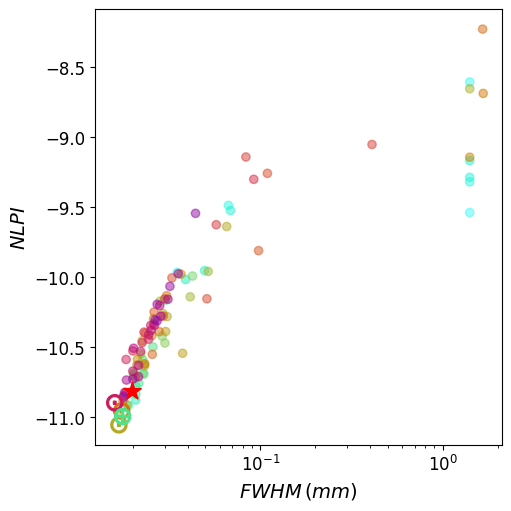

In [47]:
plt.figure(figsize=[5, 5],constrained_layout=True)
x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.tropical_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.tropical_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.tropical_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='NS')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$FWHM\, (mm)$', fontsize=14)
plt.ylabel('$NLPI$', fontsize=14)

plt.scatter(ground['fwhm'], ground['nlpi'], color='red', marker='*', s=175, label='M')
#plt.legend(loc='best')
#plt.tight_layout()

plt.savefig(f'{out_dir}/pareto_fwhm_nlpi.svg', bbox_inches='tight', dpi=600)
plt.show()

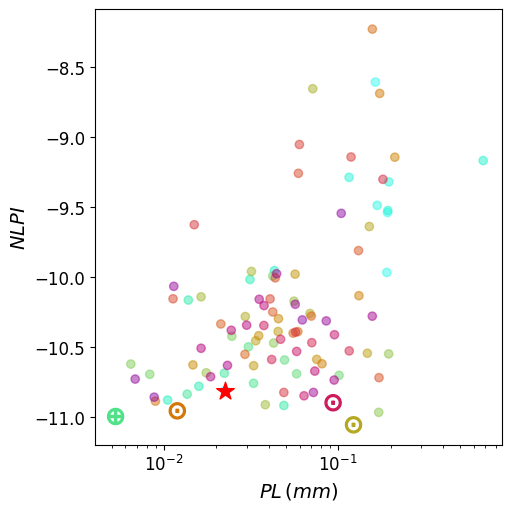

In [48]:
plt.figure(figsize=[5, 5],constrained_layout=True)
x = np.array([t.values[0] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.tropical_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.tropical_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.tropical_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='NS')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$PL\,(mm)$', fontsize=14)
plt.ylabel('$NLPI$', fontsize=14)

plt.scatter(ground['peak_distance'], ground['nlpi'], color='red', marker='*', s=175, label='M')
#plt.legend(loc='best')
#plt.tight_layout()

plt.savefig(f'{out_dir}/pareto_pl_nlpi.svg', bbox_inches='tight', dpi=600)
plt.show()

In [55]:
from matplotlib import gridspec
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu

In [57]:
props = apu.AnalyzedProps(study, nash_trial=nash_trial, max_count=max_count, min_count=200, xylim=0.15)

In [70]:
ground = {'FWHM': ground['fwhm'], 'PL': ground['peak_distance'], 'NLPI': ground['nlpi']}

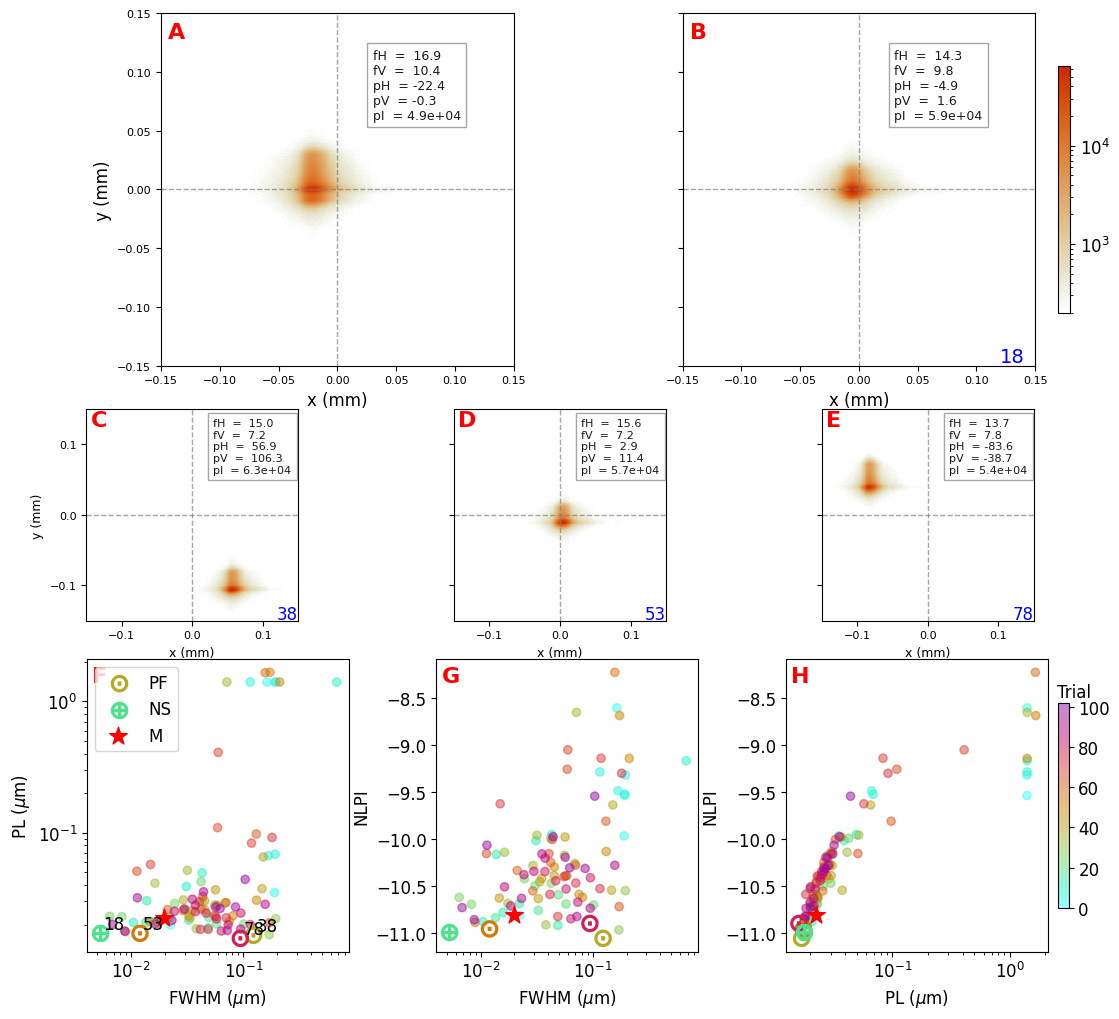

In [80]:
fig = plt.figure(figsize=[11,10], layout='constrained')
gs0 = gridspec.GridSpec(3,1, figure=fig, height_ratios=[0.4,0.25,0.35])
gss0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

axs0 = gss0.subplots(sharex=True, sharey=True)

dwd = dict(reference['dw']._DictionaryWrapper__dictionary)
hist = reference['hist']

cmesh = apu.set_ax_props(props, axs0[0], hist)
axs0[0].text(0.02,0.93, 'A', transform=axs0[0].transAxes, size=16, color='red', fontweight='bold')
apu.add_text(props, axs0[0], dwd)
axs0[0].set_ylabel('y (mm)')

#dwd = dict(study.trials[0].user_attrs['dw']._DictionaryWrapper__dictionary)
#hist = hists[0]

#cmesh = apu.set_ax_props(props, axs0[1], hist)
#apu.add_text(props, axs0[1], dwd)

#axs0[1].text(0.9, 0.01, f'{"0":>2}', fontsize=14, color='blue', transform=axs0[1].transAxes)
#axs0[1].text(0.02,0.93, 'B', transform=axs0[1].transAxes, size=16, color='red', fontweight='bold')


dwd = dict(nash_trial.user_attrs['dw']._DictionaryWrapper__dictionary)
hist = hists[nash_trial.number]
cmesh = apu.set_ax_props(props, axs0[1], hist)
apu.add_text(props, axs0[1], dwd)
axs0[1].text(0.9, 0.01, f'{nash_trial.number:>2}', fontsize=14, color='blue', transform=axs0[1].transAxes)
axs0[1].text(0.02,0.93, 'B', transform=axs0[1].transAxes, size=16, color='red', fontweight='bold')

plt.colorbar(cmesh, ax=axs0, pad=0.01,shrink=0.7)

gss1 = gridspec.GridSpecFromSubplotSpec(1, len(study.best_trials) - 1, subplot_spec=gs0[1])

axs1 = gss1.subplots(sharex=True, sharey=True)

_trials = [t for t in study.best_trials if t.number != nash_trial.number] 

current_label = 'B'
for ix, t in enumerate(_trials):
    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    
    apu.set_ax_props(props, axs1[ix], hists[t.number], labelfontsize=9, ticks=[-0.1, 0, 0.1])
    apu.add_text(props, axs1[ix], dwd, fontsize=8)
    axs1[ix].text(0.9, 0.01, f'{t.number:>2}', fontsize=12, color='blue', transform=axs1[ix].transAxes)
    
    current_label = chr(ord(current_label) + 1)
    axs1[ix].text(0.02,0.92, current_label, transform=axs1[ix].transAxes, size=16, color='red', fontweight='bold')

axs1[0].set_ylabel('y (mm)', fontsize=9)


gss2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2])
axs2 = gss2.subplots()
cscatter = apu.plot_pareto_2d(props, axs2[0], 'FWHM', 'PL', fontsize=12, annotate=True, ground=ground)
apu.plot_pareto_2d(props, axs2[1], 'FWHM', 'NLPI', fontsize=12, ground=ground)
apu.plot_pareto_2d(props, axs2[2], 'PL', 'NLPI', fontsize=12, ground=ground)

axs2[0].legend(loc='best')
for ix in range(3):
    current_label = chr(ord(current_label) + 1)
    axs2[ix].text(0.02,0.92, current_label, transform=axs2[ix].transAxes, size=16, color='red', fontweight='bold')
    
cbar = plt.colorbar(cscatter, ax=axs2, pad=0.01, shrink=0.7, location='right')
cbar.ax.text(-0.1, 105.0,'Trial')



#gs0.tight_layout(pad=0, figure=fig)
fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0.05,
                            wspace=0.01)
plt.savefig(f'{out_dir}/fig_combined.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### The remaining part is just testing how lwsi with thresholding performs in selecting the structures. This is for my own satisfaction. - SK

In [40]:
new_hists = []
new_dws = []
for h in hists:
    h1, dw = analysis.recalculate_info(h, noise_threshold=1.5, crop=500)
    new_hists.append(h1)
    new_dws.append(dw)

In [41]:
wsums = [opt_common._get_weighted_sum_intensity_from_hist(h1, 2) for h1 in new_hists]

In [42]:
wsums = np.array(wsums)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_33980/436633895.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums[t.number]),


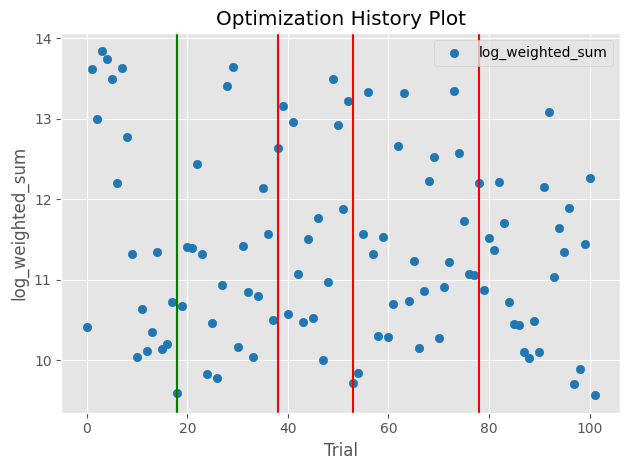

In [43]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums[t.number]),
                                                          target_name="log_weighted_sum")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_33980/4268674650.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: sigmas[t.number],


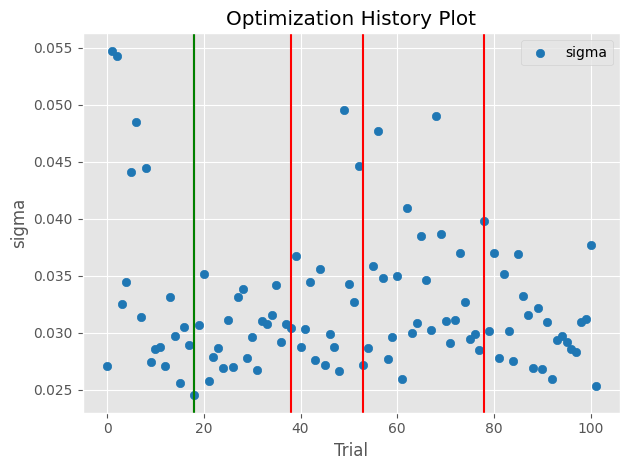

In [44]:
# Plotting the optimization histories
sigmas = [opt_common._get_sigma_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: sigmas[t.number],
                                                          target_name="sigma")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_33980/3370862287.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number],


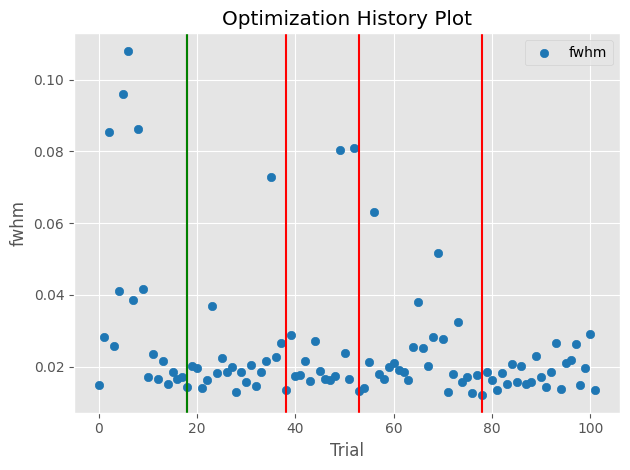

In [45]:
# Plotting the optimization histories
fwhms = [opt_common._get_fwhm_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number],
                                                          target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_33980/3952178995.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: kl_divs[t.number],


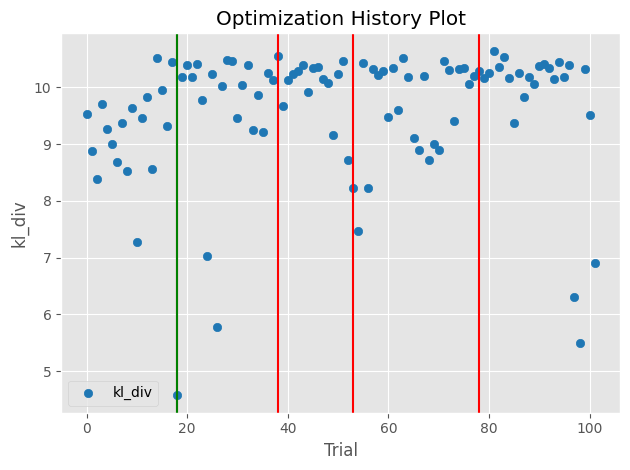

In [46]:
# Plotting the optimization histories
kl_divs  = [opt_common._get_kl_divergence_with_gaussian_from_hist(hist, ref_fwhm=(5e-3,5e-3)) for hist in new_hists]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: kl_divs[t.number],
                                                          target_name="kl_div")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_33980/330897592.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: plocs[t.number],


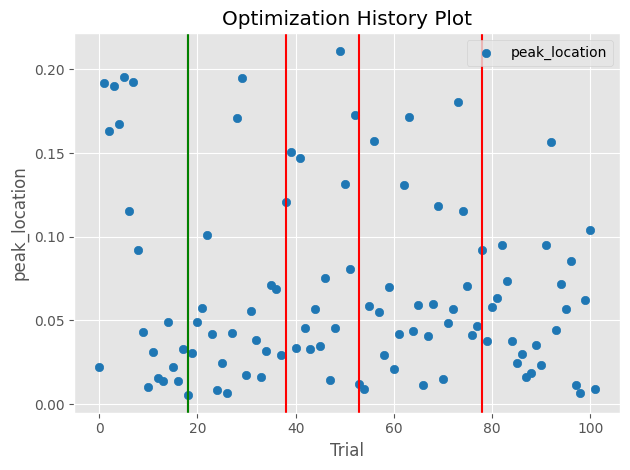

In [47]:
# Plotting the optimization histories
plocs = [opt_common._get_peak_distance_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: plocs[t.number],
                                                          target_name="peak_location")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [1]:
# Plotting the optimization histories
pints = [-np.log(opt_common._get_peak_intensity_from_dw(dw)) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: pints[t.number],
                                                          target_name="peak_intenisty")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

NameError: name 'new_dws' is not defined

In [49]:
np.argmin(kl_divs)

18

In [51]:
# FWHM, WSUM

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
                lambda t: np.log(wsums[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

101 5


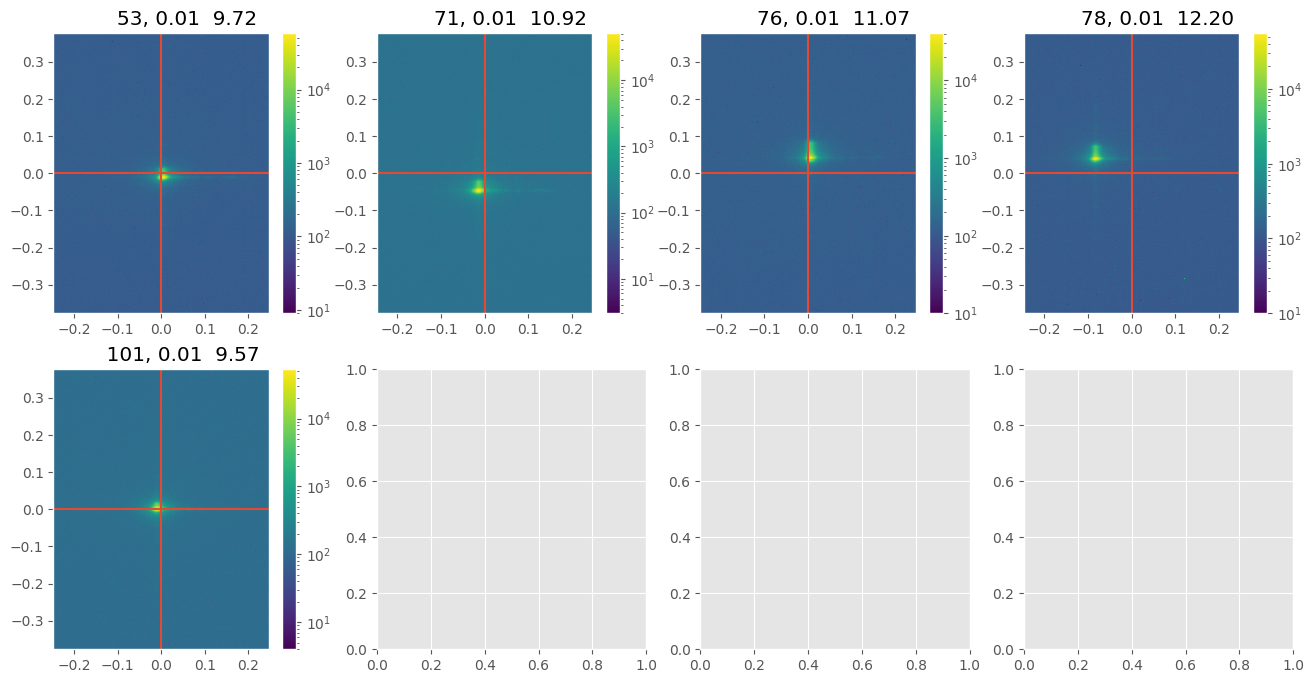

In [52]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [54]:
# FWHM, KL

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

101 5


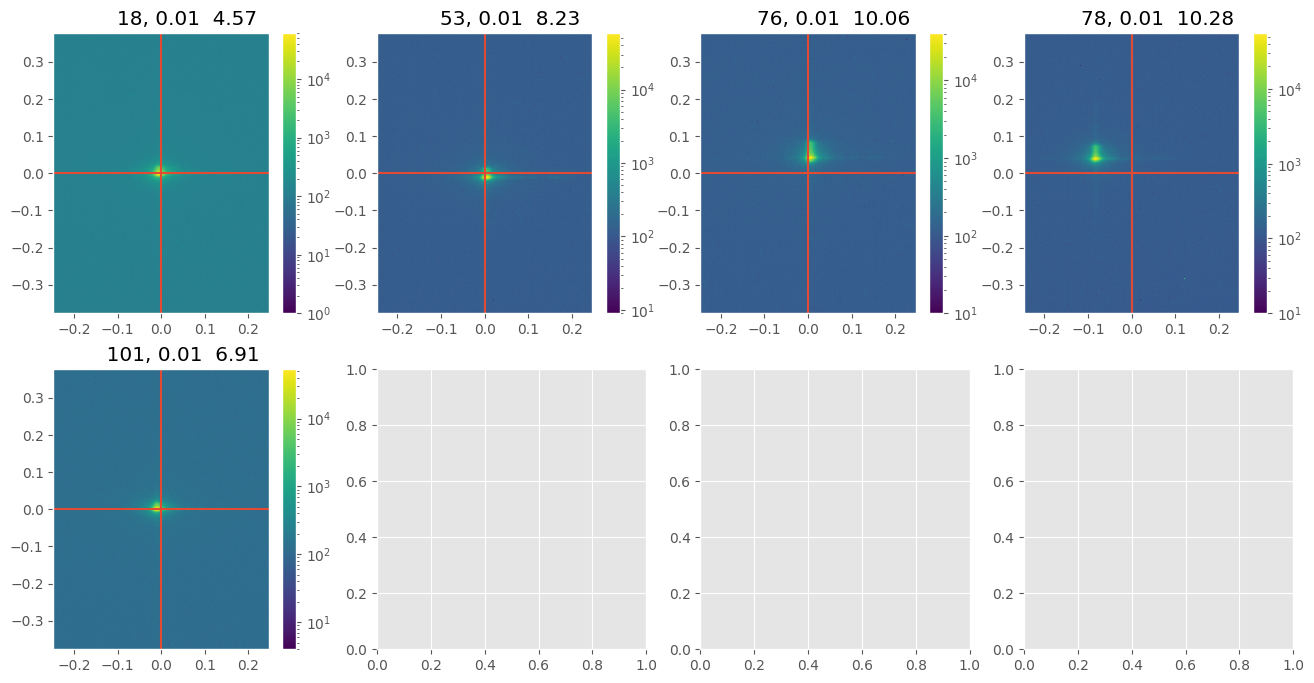

In [55]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [56]:
# centroid, KL

test_val_fns = [lambda t: opt_common._get_centroid_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

18 1


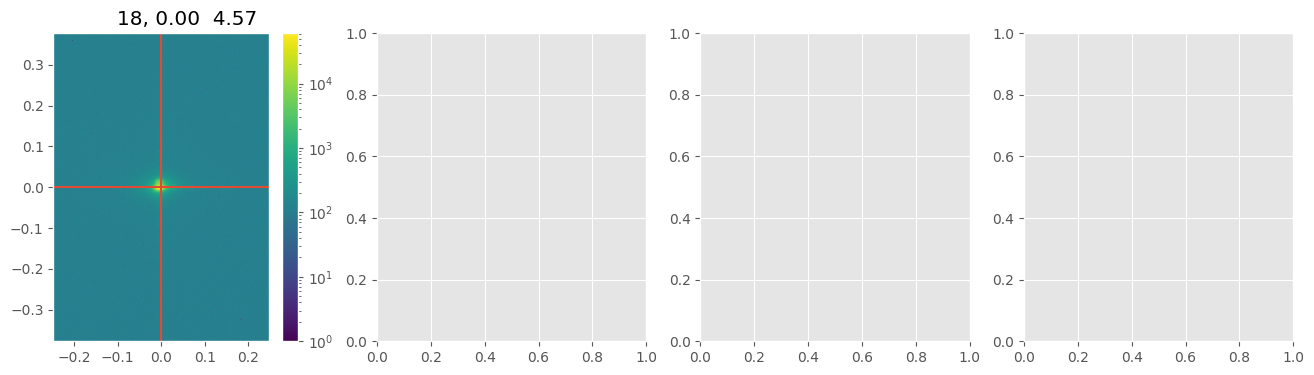

In [57]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [58]:
# peak_location, KL

test_val_fns = [lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

18 1


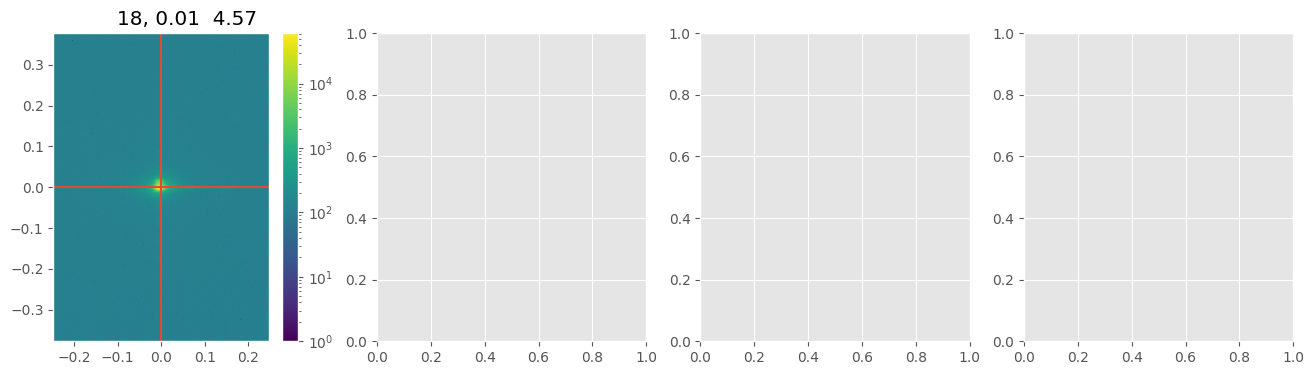

In [59]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [60]:
# peak_intensity, KL

test_val_fns = [lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])), 
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

18 2


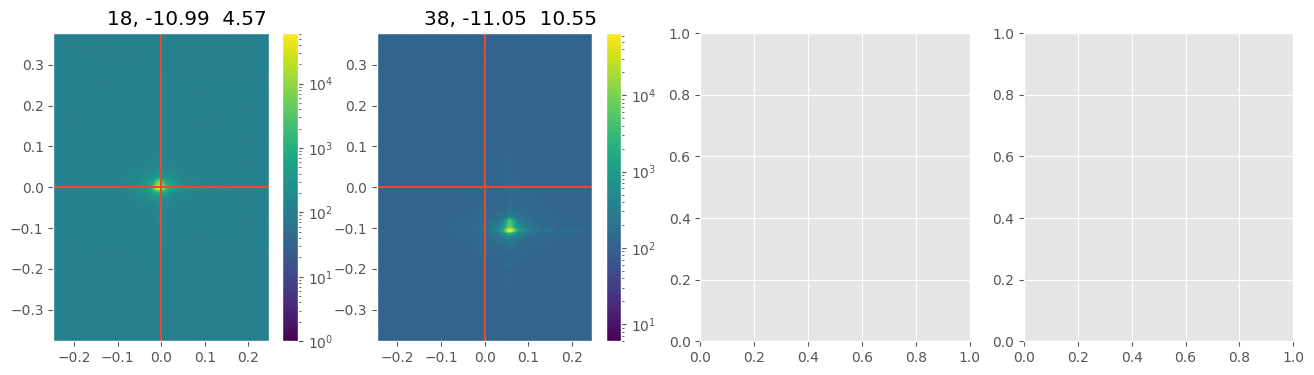

In [61]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [62]:
# peak_intensity, peak_location, KL

test_val_fns = [lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])), lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

18 2


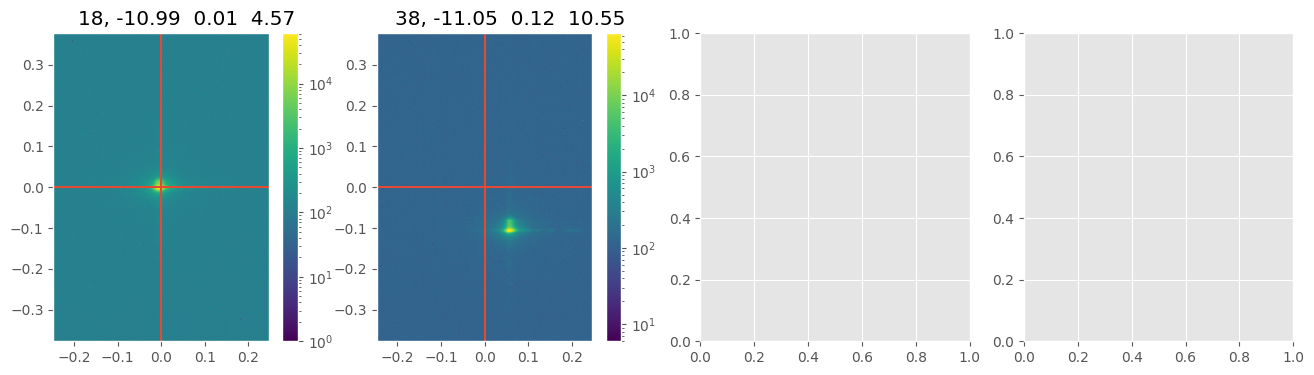

In [63]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [ ]:
isums = []
wsums_no_thres = []
wsums_thres = []
for h in hists:
    isum1, wsum1 = analysis.calculate_weighted_sum(h, threshold=0)
    isum2, wsum2 = analysis.calculate_weighted_sum(h)
    isums.append((isum1, isum2))
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
isums = np.array(isums)
wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)
                      

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/214102518.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),


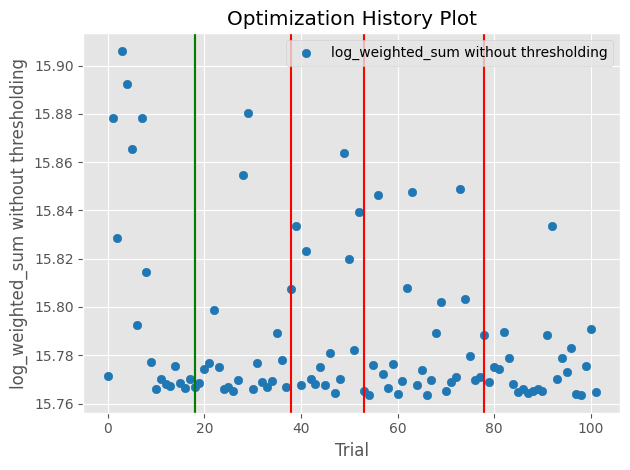

In [26]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),
                                                          target_name="log_weighted_sum without thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/2958963105.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),


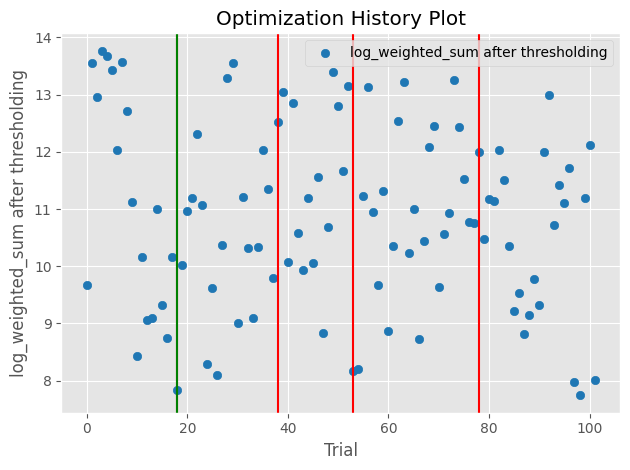

In [27]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),
                                                          target_name="log_weighted_sum after thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [28]:
test_val_fns = [lambda t: t.values[0], lambda t: t.values[2], lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, study.directions, values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins))

18


18 [0.005141044125161722, -10.987288475036621, 7.832236571125931]


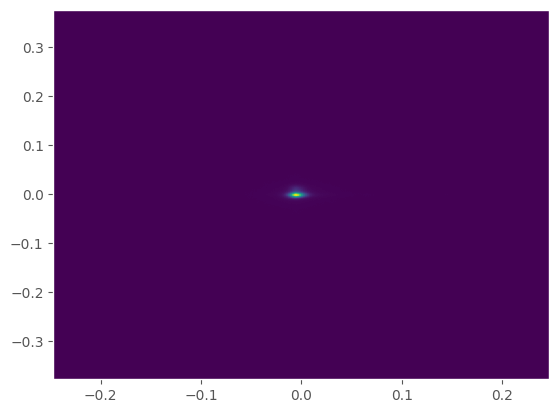

38 [0.12058593362583694, -11.052510261535645, 12.516071578088763]


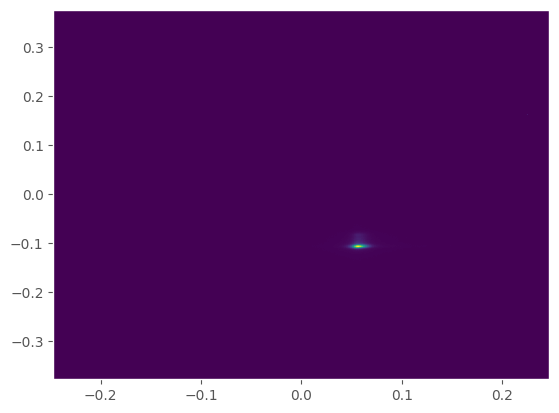

98 [0.00683549445134668, -10.72607135772705, 7.740023168335555]


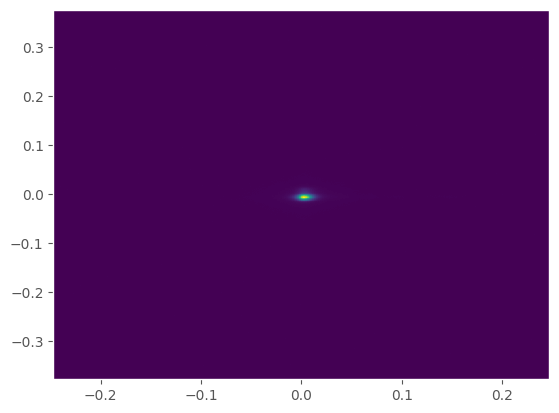

In [29]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()

In [30]:
test_val_fns = [lambda t: t.values[0], lambda t: opt_common._get_fwhm_from_dw(t.user_attrs['dw']), lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])

18 96
